<a href="https://colab.research.google.com/github/ramanakshay/Optimal-Transport/blob/main/notebooks/dispersion_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dispersion Simulation

## Import Libraries

In [ ]:
!pip install pot  # Pip Installs Packages

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
user = 'ramanakshay'
repo = 'Optimal-Transport'

url = f"git+https://github.com/{user}/{repo}.git"
!pip install --upgrade {url}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ramanakshay/Optimal-Transport.git to /tmp/pip-req-build-tkugyoon
  Running command git clone -q https://github.com/ramanakshay/Optimal-Transport.git /tmp/pip-req-build-tkugyoon


In [ ]:
import numpy as np 

import matplotlib.pyplot as plt # plotting

import ot  # ot
import ot.plot
from prettytable import PrettyTable

from tqdm import tqdm #progress bar
from IPython.display import clear_output

import time # measure time
from numpy import random
import math

In [ ]:
from utils.plot import plot_matrix,plot_2d_map
from utils.dist import find_cost_tensor
from utils.data import gaussian_mix,dispersion_density,uniform_density,lorentzian

## Sinkhorn Algorithm for dissociation

In this document we will implement the Sinkhorn algorithm written by Akshay Raman to study qualitatively the dissasociation of **two atoms**. For that porpuse, we use the entropic regularization of the strictly correleted electron functional:
\begin{equation}
\begin{aligned}
& V^{SCE}_{\tau}[\rho]= \min\limits_{\gamma \rightarrow \rho} \left[\int \prod _{k=1}^{N} d\vec{r}_k\sum_{1 \leq <i<j\leq N} \frac{\gamma(\vec{r}_1,\vec{r}_2,...\vec{r}_N)}{|\vec{r}_i-\vec{r}_j|}   \\
+ \tau \int \prod _{k=1}^{N} d\vec{r}_k \gamma(\vec{r}_1,\vec{r}_2,...\vec{r}_N)\left( \log(\gamma(\vec{r}_1,\vec{r}_2,...\vec{r}_N)) -1   \right) \right ],
\end{aligned}
\end{equation}
where $\tau$>0 is a small real number and the second term is minus Shannon_Von Neumann entropy.
Fortunately, for this entropic regularized problem we have an analytical solution for $\gamma$:

\begin{equation}
\gamma^{\tau}(\vec{r}_1,\vec{r}_2,...\vec{r}_N)=\prod_{i=1}^{N}e^{\frac{u^{\tau}(\vec{r}_i)}{\tau}}e^{\frac{-V_{ee}(\vec{r}_1,\vec{r}_2,...\vec{r}_N)}{\tau}}.
\end{equation}
The functions $u^{\tau}(\vec{r}_i)$ are the Kantorovich potentials, which play the role of the external potentialls and are the responsible of keeping fixed the one body density $\rho$. If we integrate over all the coordinates except one, let's say the $j$th coordinate, we obtain the one body density $\rho$. Now, if we do that for all possible $j$, we end up with a set of equations that can be solved recuersevely, with the Sinkhorn algorithm, for the Kantorovich potentials and for $\gamma$. 


In [ ]:
class SinkhornSolver(object):
  def __init__(self,A,C):
    self.A = A
    self.C = C
    self.n = A.shape[0]
    self.size = A.shape[1]
  
  def initialise(self,initial):
    if (initial == "ones"):
      return np.ones((self.n,self.size))
    elif (initial == "random"):
      return random.rand(self.n,self.size)
    else:
      raise ValueError("Invalid Argument: " + initial + " is not a valid type.")

#-----------------------------HELPER FUNCTIONS---------------------------------#
  def multiply(self,P,U,i):
    shape = [1]*self.n
    shape[i] = self.size
    shape = tuple(shape)
    temp = U[i].reshape(shape)
    return P * temp

  def divide(self,P,U,i):
    shape = [1]*self.n
    shape[i] = self.size
    shape = tuple(shape)
    temp = U[i].reshape(shape)
    return P / temp

  def sum_to_vector(self,P,i):
    axes = list(range(self.n))
    axes.remove(i)
    axes = tuple(axes)
    return np.sum(P,axis = axes)

#--------------------------------AUTO SINKHORN---------------------------------#

  def auto_sinkhorn(self,epsilon,error,initial = "ones"):
    U = self.initialise(initial)
    K = np.exp(-self.C/epsilon)
    P = np.copy(K)

    #initialise P
    for i in range(self.n):
      P = self.multiply(P,U,i)
    
    #loop
    iter = 0
    while(True):
      for i in range(self.n):
        P = self.divide(P,U,i)
        U[i] = self.A[i] / self.sum_to_vector(P,i)
        P = self.multiply(P,U,i)

      #marginal condition
      flag = True
      max_error = -1
      for i in range(self.n):
        if (np.any(abs(self.sum_to_vector(P,i) - self.A[i]) >= error)):
          flag = False
        clear_output(wait = True)
        max_error = max(max_error,np.max(abs(self.sum_to_vector(P,i) - self.A[i])))
      if(flag):
        break

      print("Maximum Error:",max_error)
      print("#Iterations:",iter)
      
      iter += 1

    #return coupling  
    return P,U

### One-body density

To model the dissociation of the electrons we choose the one-body density as a superpostion of two Gaussian with their center separated a distance $R$
$$ f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2}\left (  \frac{x-R/2}{\sigma}\right )^2} + \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2}\left (  \frac{x+R/2}{\sigma}\right )^2} $$

where $\sigma$ is the standard deviation of each gaussian. So, for $R=0$ the electrons will be close to each other, but as we increase $R$ the separation between them becomes bigger and eventually the electrons will dossociate.

In [ ]:
def gaussian_mix(size,mu,std,scale = None):
  assert len(mu) == len(std)
  if scale == None:
    scale = [1]*len(mu)
  x = np.arange(size, dtype = np.float64)
  h = 0
  for i in range(len(mu)):
    h += np.exp(-(x - mu[i]) ** 2 / (2 * std[i] ** 2))*scale[i]
  return h / h.sum()

def dispersion_density(size,R):
  assert R <= 58*size/64  and R >= 0
  return gaussian_mix(size,[size//2 + R/2,size//2 - R/2],[size/64,size/64],[1,1.5])

def uniform_density(size):
  return 1/size * np.ones((size,))

In [ ]:
n = 2
size = 200

A = np.empty((n,size), float)
# All marginals are the same
for i in range(n):
  A[i] = dispersion_density(size,125)

x = np.array([[i,] for i in range(size)]) # defining the space
X = np.tile(x.T,(n,1))

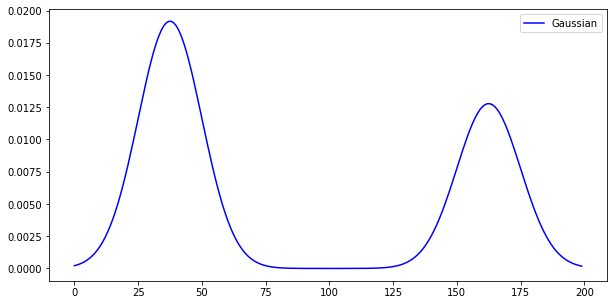

In [ ]:
#Plot distributions
plt.figure(figsize=(10, 5))
plt.plot(x, A[0], 'b',label = 'Gaussian')
plt.legend()
plt.show()

###**Coulomb interaction** 
$$ C = \sum_{1 \leq i < j \leq n}{\frac {1}{\left | 1 + (r_i - r_j) \right | }} $$

(200, 200)


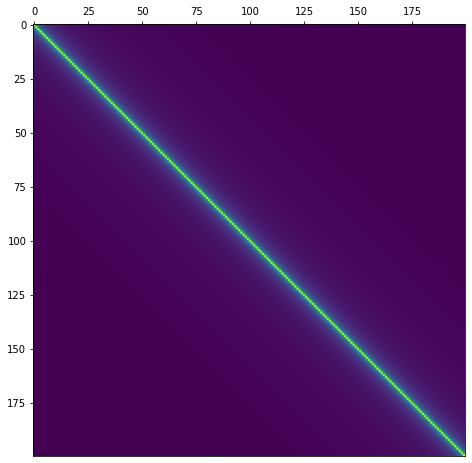

In [ ]:
C = find_cost_tensor(X)
print(C.shape)
#Cm = np.sum(C,axis = (2))
plot_matrix(C,x,x)

###**Probability density**
Here we apply the Sinkhorn algorithm to find the probability density $\gamma^{\tau}(\vec{r}_1,\vec{r}_2,...\vec{r}_N)$ for $R=$ . Now, since we can not plot probability densities for more than 2 dimensions, we project $\gamma$ in the plane and obtain the following result.



In [ ]:
solver = SinkhornSolver(A,C)

In [ ]:
output=solver.auto_sinkhorn(1e-3,1e-5,initial="random")
P = output[0]
Ae = output[1]
U=1e-3*np.log(Ae)

Maximum Error: 1.0172581095254513e-05
#Iterations: 144


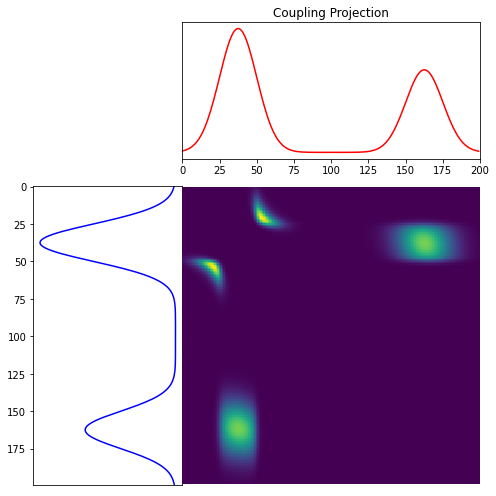

In [ ]:
#Pm = np.sum(P,axis = (2))

plt.figure(figsize=(7, 7))
ot.plot.plot1D_mat(A[0], A[1], P, 'Coupling Projection')

From this plot we can distinguish two types of solutions for the probability density depending on the region of interaction. The first one in the top left-hand corner corresponds to solution for the repulsive interaction between the electrons inside of the bigger gaussian, which give us the Mike Seidl's solution. The second one, in the top right-hand corner and bottom left-hand corner, corresponds to the probability density associated with the attractive interaction between the electrons of one Gaussian and the nuclei of the atoms of the other gaussian.

###**Kantorovich potentials**
From the implemented Sinkhron ALgorithm we also can obtain the Kantorovich potentials for the system, but since we are working with a unique one-body dendity, all the kantorovich potentials are the same. For $R=$ we have

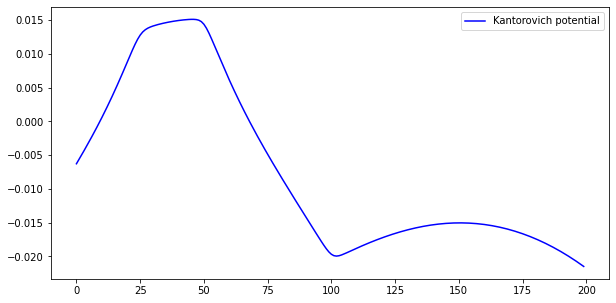

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(x, U[0], 'b',label = 'Kantorovich potential')
plt.legend()
plt.show()

From this plot we can highlight three regions. For $0 < x < 75$ and For $125 < x < 200$ we have a repulsive potential, that corresponds to the repulsion between the atoms inside of each gaussian. The region $75 < x < 125$ is an attractive one, which show us the interaction between the nuclei of the atoms in one gaussian with the electrons on the other gaussian.

###**Dependency of the probability distribution with R:**
In order to see the dissasociation of the two atoms we here plot the probability distribution for five different values of $R$

---



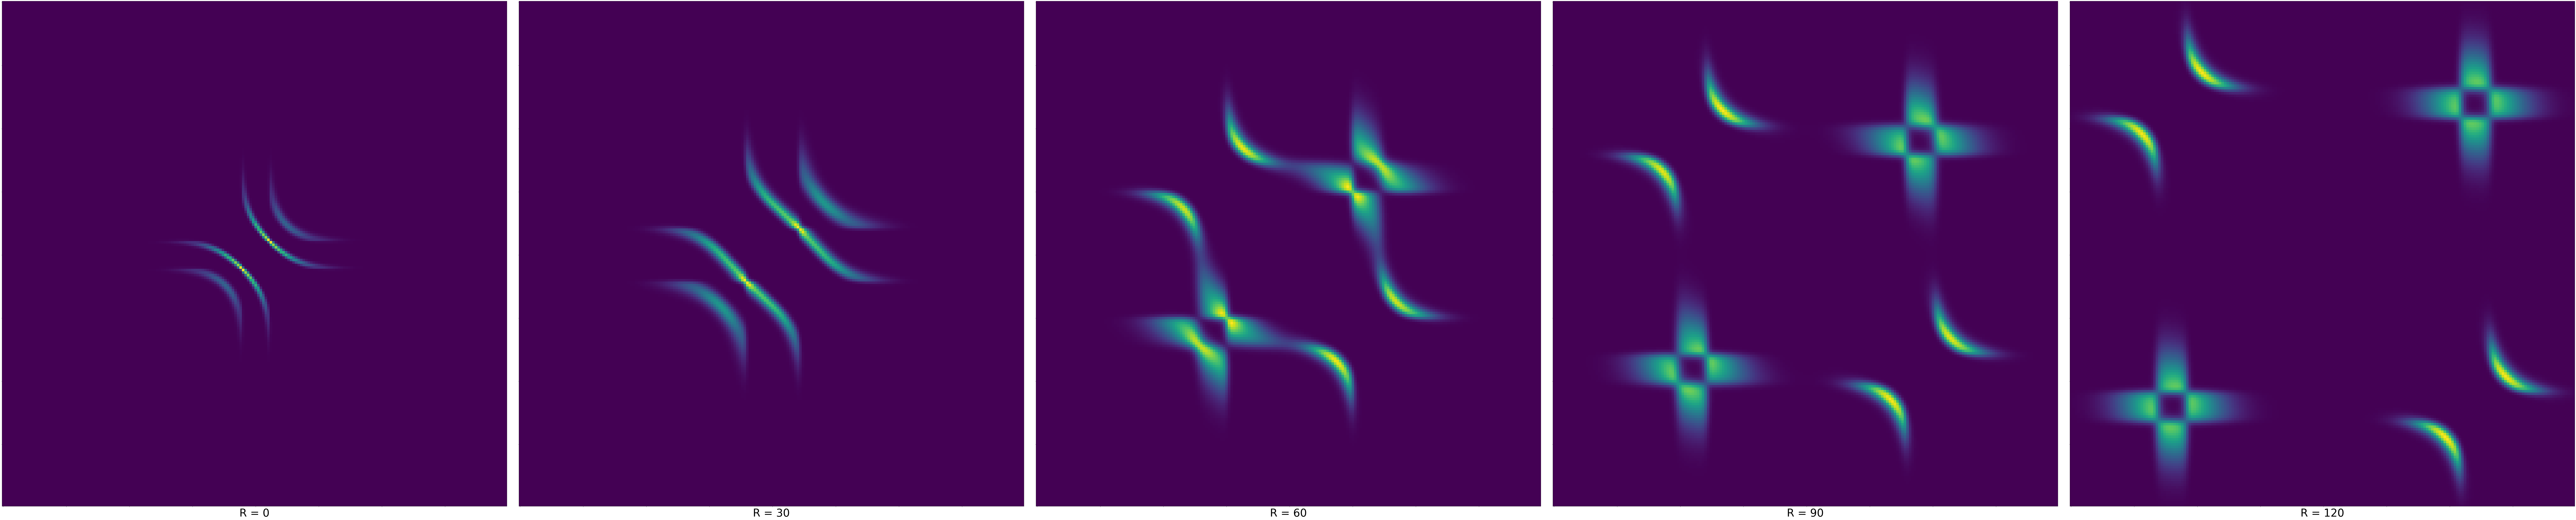

In [ ]:
R = 0
n = 3 #number of marginals
size = 200 #size of the space 
x = np.array([[k,] for k in range(size)]) # defining the space
X = np.tile(x.T,(n,1))
C = find_cost_tensor(X)
Cm = np.sum(C,axis = (2))
A = np.empty((n,size), float)
fig, axs = plt.subplots(1, 5, constrained_layout=True)
fig.set_figheight(200)
fig.set_figwidth(200)

i = 0
times = []
for R in [0,30,60,90,120]:
  for j in range(n):
    A[j] = dispersion_density(size,R)
  solver = SinkhornSolver(A,C)
  output=solver.auto_sinkhorn(1e-3,1e-3,initial="random")
  P=output[0]  
  Pm = np.sum(P,axis = (2))
  axs[i].imshow(Pm)
  axs[i].set_xlabel('R = ' + str(R) ,size = 60)
  axs[i].set_xticklabels([])
  axs[i].set_yticklabels([])
  i += 1

From this plots we see a behavior similar to the one described above. For $R=0$ the two gaussians are together so we only have the probability distribution for $N$ interacting electrons in ony dimension, that, as we know, gives the Mike Sield's solution. As we increase $R$ the interaction between the atoms of each gaussian becomes more relevant, as can be seen for $R=120$, that we have the four solutions, two repulsive and two attractive, with the same interpretation given before. 

###**Dependency of the probability distribution with R:**


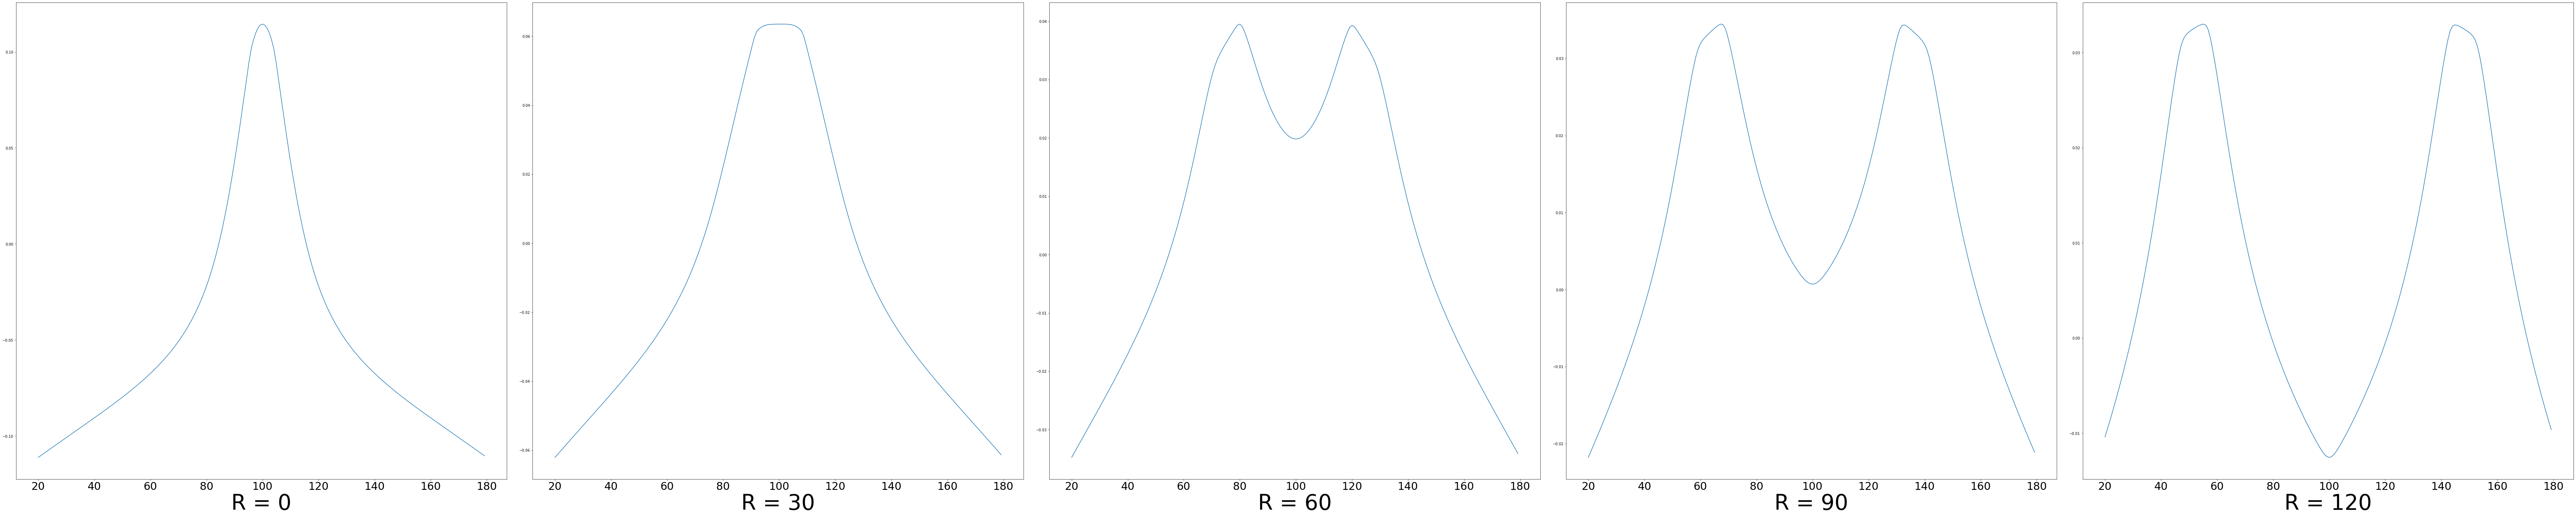

In [ ]:
R = 0
fig, axs = plt.subplots(1, 5, constrained_layout=True)
fig.set_figheight(20)
fig.set_figwidth(100)
n = 3 #number of marginals
size = 200 #size of the space
A = np.empty((n,size), float) 
x = np.array([[k,] for k in range(size)]) # defining the space
X = np.tile(x.T,(n,1))
C = find_cost_tensor(X)
Cm = np.sum(C,axis = (2))
i = 0
times = []
for R in [0,30,60,90,120]:
  for j in range(n):
    A[j] = dispersion_density(size,R)
  solver = SinkhornSolver(A,C)
  output=solver.auto_sinkhorn(1e-3,1e-3,initial="random")
  Ae = output[1]
  U=1e-3*np.log(Ae)
  axs[i].plot(x, U[0])
  axs[i].set_xlabel('R = ' + str(R) ,size = 60)
  axs[i].set_xticklabels([0,20,40,60,80,100,120,140,160,180,200],size=30)
  #axs[i].set_yticklabels(size=30)
  i += 1

###**Dissasociation curve**
Now, we plot the total potential energy of the system as function of $R$. 

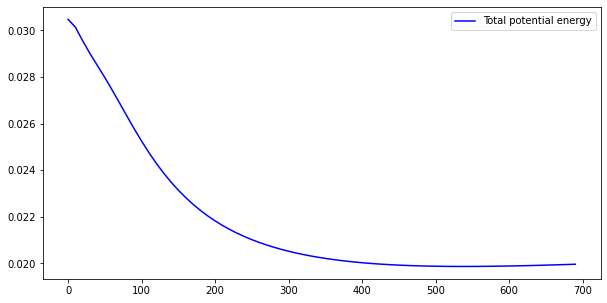

In [ ]:
r = [] # R values
y = [] # V values
R=0
N=2 #number of marginals
size=1000
x = np.array([[k,] for k in range(size)]) # defining the space
X = np.tile(x.T,(N,1))
C = find_cost_tensor(X)
A = np.empty((N,size), float)
i=0
for R in range(0,600,10):
  r.append(R)
  for j in range(N):
    A[j] = dispersion_density(size,R)
  solver = SinkhornSolver(A,C)
  output=solver.auto_sinkhorn(1e-3,1e-6,initial="ones")
  P=output[0]
  Ae = output[1]
  U=-1e-3*np.log(Ae)
  K= np.sum(A[0]*U[0])
  V = np.sum(C*P)
  y.append(V+2*K)
plt.figure(figsize=(10, 5))
plt.plot(r, y, 'b',label = 'Total potential energy')
plt.legend()
plt.show()  

With this plot we are trying to qualitatively reproduce the behavior of the attractive limit of the Lennard-Jones Potential. As can be seen from the plot, we have an initial strong repulsion when $R$  goes to 0. Besides, when R start increasing, we find the slightly attraction described in the Lennard-Jones Potential. 

## **Comparison with anaylitical examples**
From the litterature we know that the strictly correleted electron limit for the Levy-Lieb functional has an analytical solution for the particular case of 1D. This solution is given in terms of Mike Sield's co-motion functions. Having that in mind, we here compare the analytical solution obtained for a Lorentzian and Uniform density with the solution given by the Sinkhorn algorithm.



###**Lorentzian density**
Consider we have $N=2$ electrons in 1-D described by a one body density like:
\begin{equation}
\rho(x)=\frac{2}{\pi(1+x^2)},
\end{equation}
A lorentzian density.  
For this kind of density we have obtained the exact analytical expression for the probability density $\gamma(x,y)$ and kantorovich potential $u(x)$:

\begin{equation}
\gamma(x)=\frac{\rho(x)}{2}\delta \left(x+\frac{1}{x} \right)
\end{equation}

\begin{equation}
u(x)= \left\{ \begin{array}{lcc}
             \arctan(x)-\frac{x}{2(x^2+1)} &   if  & x < 0 \\
             \\ \frac{x}{2(x^2+1)} - \arctan(x) &  if  & x > 0
             \end{array}
   \right.
\end{equation}
So, we'll compare this solution to the one obtain using the Sinkhorn algortitm.




In [ ]:
n = 2
size = 200

A = np.empty((n,size), float)
# All marginals are the same
for i in range(n):
  A[i] = lorentzian(size)
x = np.array([[i,] for i in range(size)]) # defining the space
X = np.tile(x.T,(n,1))

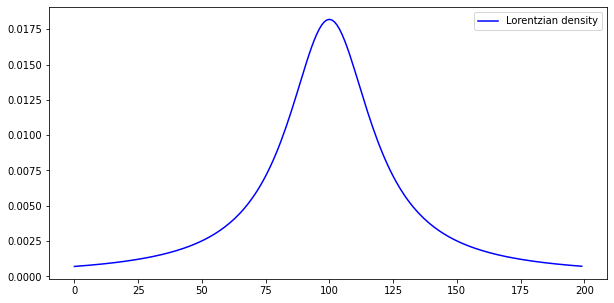

In [ ]:
#Plot Lorentzian dentisy distributions
plt.figure(figsize=(10, 5))
plt.plot(x, A[0], 'b',label = 'Lorentzian density')
plt.legend()
plt.show()

(200, 200)


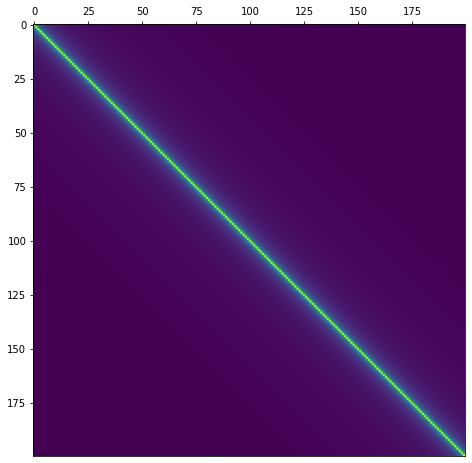

In [ ]:
C = find_cost_tensor(X)
print(C.shape)
#Cm = np.sum(C,axis = (2))
plot_matrix(C,x,x)

#####**Probability density**


In [ ]:
solver = SinkhornSolver(A,C)

In [ ]:
output=solver.auto_sinkhorn(1e-3,1e-4,initial="random")
P = output[0]
Ae = output[1]
U=-1e-3*np.log(Ae)

Maximum Error: 0.00010238472886635666
#Iterations: 53


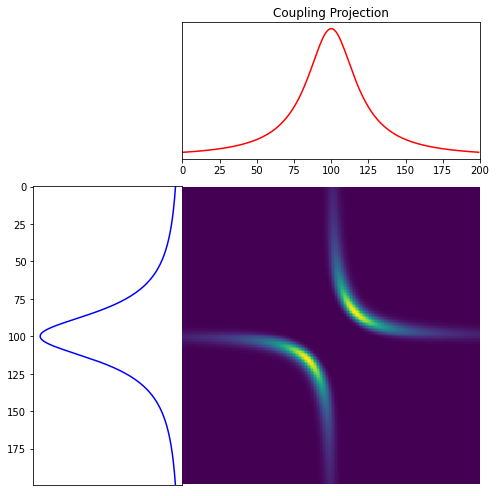

In [ ]:
#Pm = np.sum(P,axis = (2))

plt.figure(figsize=(7, 7))
ot.plot.plot1D_mat(A[0], A[1], P, 'Coupling Projection')

This distribution effectively corresponds to the one found analitically for the Lorentzian density, the feature we can highlight is that the smaller we take $\tau$, the thinner the distribution will be, approximating the delta function of the analytical solution 

#####**Kantorovich potential** 

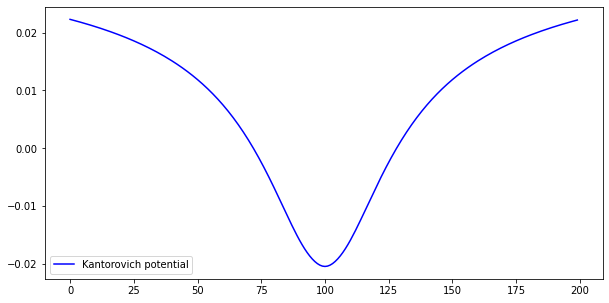

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(x,U[0], 'b',label = 'Kantorovich potential')
plt.legend()
plt.show()

We thus find from the Sinkhorn algorithm the same attractive kantorovich potential found analytically



###**Uniform density**
Consider we have $N=2$ electrons in 1-D described by a one body density like:
\begin{equation}
\rho(x)=\frac{1}{200}, ~~~~ 0 < x < 200 
\end{equation}
A lorentzian density.  
For this kind of density we have obtained the exact analytical expression for the probability density $\gamma(x,y)$ and kantorovich potential $u(x)$:

\begin{equation}
\gamma(x)= \left\{ \begin{array}{lcc}
             x + \frac{1}{2} &   if  & x < 1/2 \\
               x - \frac{1}{2} &  if  & x > 1/2
             \end{array}
   \right.,
\end{equation}

\begin{equation}
u(x)= \left\{ \begin{array}{lcc}
             -4x + c &   if  & x < 1/2 \\
             4x + c &  if  & x > 1/2
             \end{array}
   \right.,
\end{equation}
where $c$ is a constant.

Now, we compare this solution to the one obtain using the Sinkhorn algortitm.


In [ ]:
n = 2
size = 200

A = np.empty((n,size), float)
# All marginals are the same
for i in range(n):
  A[i] = uniform_density(size)
x = np.array([[i,] for i in range(size)]) # defining the space
X = np.tile(x.T,(n,1))

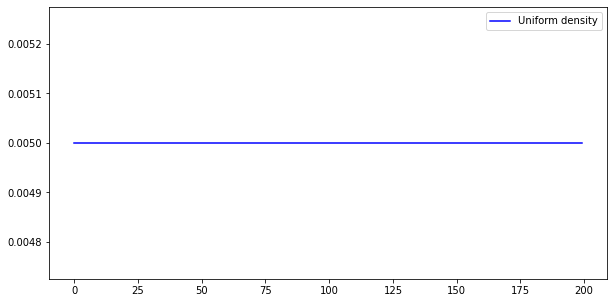

In [ ]:
#Plot Lorentzian dentisy distributions
plt.figure(figsize=(10, 5))
plt.plot(x, A[0], 'b',label = 'Uniform density')
plt.legend()
plt.show()

(200, 200)


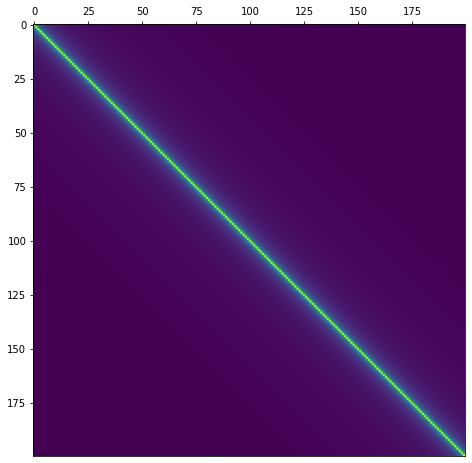

In [ ]:
C = find_cost_tensor(X)
print(C.shape)
#Cm = np.sum(C,axis = (2))
plot_matrix(C,x,x)

#####**Probability density**


In [ ]:
solver=SinkhornSolver(A,C)

In [ ]:
output=solver.auto_sinkhorn(1e-3,1e-5,initial="random")
P = output[0]
Ae = output[1]
U=-1e-3*np.log(Ae)

Maximum Error: 1.1212481298440366e-05
#Iterations: 14


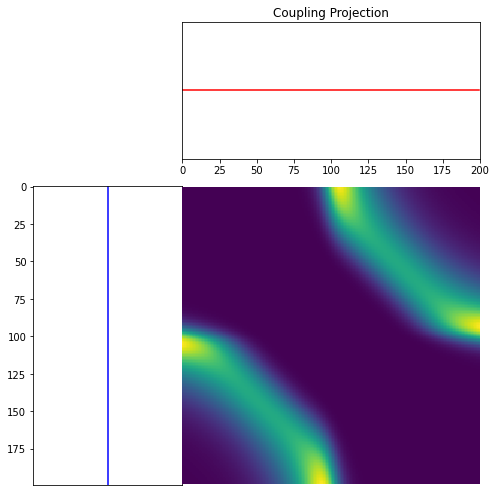

In [ ]:
#Pm = np.sum(P,axis = (2))

plt.figure(figsize=(7, 7))
ot.plot.plot1D_mat(A[0], A[1], P, 'Coupling Projection')

This distribution corresponds to the one found analitically for the uniform density, the feature we can highlight is that the smaller we take  τ , the thinner the distribution will be, approximating the delta function of the analytical solution:

#####**Kantorovich potential** 

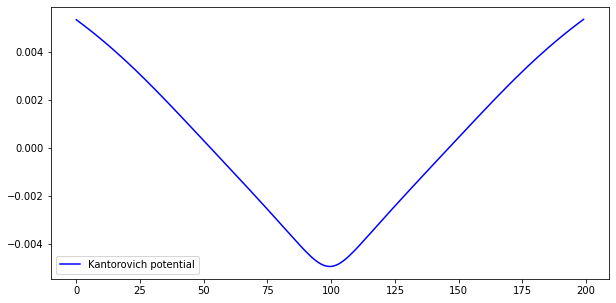

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(x,U[0], 'b',label = 'Kantorovich potential')
plt.legend()
plt.show()

Finally, we find again that for the uniform density the Sinkhorn algorithm also give us a precise answer for the kantorovich potential